# Lab 2 - Travelling Salesman Problem (TSP)

## Imports

In [170]:
import functools
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dataclasses import dataclass


## General constants

In [171]:
PATH = "cities/"
INSTANCES = [
    "vanuatu.csv",
    "italy.csv",
    "russia.csv",
    "us.csv",
    "china.csv"
]
BEST_RESULTS = [
    -1_345.54,
    -4_172.76,
    -32_722.5,
    -39_016.62,
    None
] 

## Classes

In [172]:
class City:
    
    @staticmethod
    def distance(start, end):
        return geopy.distance.geodesic(
            (start.lat, start.lon), (end.lat, end.lon)
        ).km
    
    def __init__(self, name, lat, lon):
        self.name: str = name
        self.lat: float | np.float64 = lat
        self.lon: float | np.float64 = lon
        
    def __repr__(self):
        return f"{self.name}"
    
    def __str__(self):
        return f"{self.name} ({self.lat}°, {self.lon}°)"

In [173]:
@dataclass
class Individual:
    genome: np.ndarray
    fitness: np.float64 | float = None

## Helper functions

In [174]:
def distance_matrix(coordinates: list) -> np.ndarray:
    num_cities = len(coordinates)
    dist_matrix = np.zeros((num_cities, num_cities))
    
    for i in range(num_cities):
        for j in range(i+1):
            dist_matrix[i, j] = dist_matrix[j, i] = City.distance(coordinates[i], coordinates[j]) if i != j else 0
          
    return dist_matrix

def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def cost(solution: np.ndarray, dist_matrix: np.ndarray) -> np.float64 | float:
    #print(solution, dist_matrix)
    """Cost of a cycle"""
    return np.sum(
        np.array([
            dist_matrix[start, end] for (start, end) in zip(solution[:-1], solution[1:])
        ])
    )
    
    
def fitness(individual, dist_matrix):
    solution = np.array(individual.genome.tolist() + [individual.genome[0]])
    return -cost(solution, dist_matrix)


def parent_selection(population):
    BUCKET_SIZE = 10
    candidates = sorted(np.random.choice(population, BUCKET_SIZE), key=lambda e: e.fitness, reverse=True)
    return candidates[0]


def cycle_xover(p1: Individual, p2: Individual):
    
    #print(p1, p2)
    
    a, b = np.random.randint(0, p1.genome.size-1), np.random.randint(0, p1.genome.size-1)
    l1, l2 = min(a, b), max(a, b)
    segment = p1.genome[l1:l2+1]
    
    genome = p1.genome.copy()
    genome[l1:l2+1] = p1.genome[l1:l2+1]
    others = p2.genome[~np.isin(p2.genome, segment)]
    
    
    # print(p1.genome, p2.genome)
    # print(l1, l2, genome, genome[l2+1:], others, others[l1:])
    
    assert (len(others) - l1) == (len(genome) - (l2+1))
    
    genome[:l1] = others[:l1]
    genome[l2+1:] = others[l1:]
    
    return Individual(genome)


def inver_over_xover(p1: Individual, p2: Individual):
    """INVER-OVER crossover"""
    genome1 = p1.genome.copy()
    genome = np.zeros(genome1.shape, dtype=np.int16)
    num_cities = p1.genome.size
    
    p1_start = np.random.randint(len(p1.genome))
    genome1 = np.roll(genome1, -p1_start)
    
    p2_start = p2.genome.tolist().index(genome1[0])
    p1_end = genome1.tolist().index(p2.genome[(p2_start+1) % num_cities])
    
    genome[0] = genome1[0]
    genome[1] = genome1[p1_end]
    
    genome[2:p1_end+1] = genome1[1:p1_end][::-1]
    genome[p1_end+1:] = genome1[p1_end+1:]
    genome = np.roll(genome, p1_start)
    
    return Individual(genome)

xover = inver_over_xover

def scramble_mutation(p: Individual):
    SIGMA = 0.5
    genome = p.genome.copy()
    mask = np.random.random(len(genome)) < SIGMA
    genome[mask] = np.random.permutation(genome[mask])
    return Individual(genome)


def inversion_mutation(p: Individual):
    a, b = np.random.randint(0, p.genome.size-1), np.random.randint(0, p.genome.size-1)
    l1, l2 = min(a, b), max(a, b)
    
    genome = p.genome.copy()
    genome = np.roll(genome, -l1)
    genome[:l2-l1+1] = genome[:l2-l1+1][::-1]
    
    return Individual(genome)
    

mutation = inversion_mutation

## Greedy

In [175]:
def greedy_solve(coordinates, dist_matrix, start_index, rnd):
    """Greedy algorithm with random initialization: sub-optimal"""
    temp = dist_matrix.copy()
    
    num_cities = len(coordinates)
    visited = np.full(num_cities, False)
    
    solution = -np.ones(num_cities+1, dtype=np.int16)
    solution[0], visited[0] = start_index, True
    for step in range(num_cities-1):
        temp[:, start_index] = np.inf
        p = np.random.rand()
        if rnd and p < 0.01 and step < num_cities - 3:
            next_index = np.argsort(temp[start_index])[2]
        elif rnd and p < 0.1 and step < num_cities - 2:
            next_index = np.argsort(temp[start_index])[1]
        else:
            next_index = np.argmin(temp[start_index])
            
        solution[step+1] = next_index
        start_index = next_index
        visited[start_index] = True
        
    solution[-1] = solution[0]
    
    return solution, -cost(solution, dist_matrix)

In [176]:
def greedy_init(coordinates, dist_matrix, rnd=False):
    best_fitness, best_sol = -np.inf, None
    solutions =  []
    for start in tqdm(range(coordinates.size)):
        sol, fitness_sol = greedy_solve(coordinates, dist_matrix, start, rnd)
        solutions.append(sol[:-1])
        if fitness_sol > best_fitness:
            best_fitness = fitness_sol
            best_sol = sol
            
    return solutions, best_fitness, best_sol

## Evolutionary

In [177]:
def single_mutation(p: Individual):
    from_pos = np.random.randint(p.genome.size)
    to_pos = np.random.randint(p.genome.size)
    genome = p.genome.copy()
    genome[to_pos], genome[from_pos] = p.genome[from_pos], p.genome[to_pos]
    return Individual(genome)

In [178]:
def evolutionary_solve(coordinates, dist_matrix: np.ndarray, start_population, pop_size, max_generations):
    start_pop_len = len(start_population)
    num_cities = len(coordinates)
    #population = [Individual(np.random.permutation(num_cities)) for _ in range(pop_size)]
    population = [Individual(start_individual) for start_individual in start_population]
    
    for i in population:
        i.fitness = fitness(i, dist_matrix)
        
    for i in population:
        assert set(sorted(i.genome)) == set(i.genome.tolist()) 
    
    assert len(population) == start_pop_len and start_pop_len >= 0
        
    # Discard some individuals if too many wrt start ones
    if start_pop_len > pop_size:
        population.sort(key=lambda i: i.fitness, reverse=True)
        population = np.random.choice(population, size=pop_size, replace=False).tolist()
        np.random.shuffle(population)
        
    # Extend population if needed more individuals than start population
    elif start_pop_len < pop_size:
        population.extend(Individual(np.random.permutation(num_cities)) for _ in range(pop_size - start_pop_len))
        
        # Compute fitness for new individuals
        for i in population[start_pop_len:]:
            i.fitness = fitness(i, dist_matrix)
    
    OFFSPRING_SIZE = int(2*pop_size / 3)
    
    for i in population:
        assert set(sorted(i.genome)) == set(i.genome.tolist()) 
    
    champions = [max(population, key=lambda i: i.fitness).fitness]
    
    for gen in tqdm(range(max_generations)):
        offspring = []
        for _ in range(OFFSPRING_SIZE):
            if np.random.random() < 0.9:
                p = parent_selection(population)
                o = mutation(p)
            else:
                p1 = parent_selection(population)
                p2 = parent_selection(population)
                o = xover(p1, p2)
            
            offspring.append(o)
        
        for i in offspring:
            i.fitness = fitness(i, dist_matrix)
            
        population.extend(offspring)
        
        # Elitism + generational model
        # population.sort(key=lambda i: i.fitness, reverse=True)
        # population = population[:RETAIN_SIZE_ELITIST]
        
        # Survivor selection
        population.sort(key=lambda i: i.fitness, reverse=True)
        population = population[:pop_size]
        
        champions.append(population[0].fitness)
    
    return population[0].genome, population[0].fitness, champions

## Solver

In [179]:
MAX_GENERATIONS = [100, 1000, 2000, 2000, 5000]
POPULATION_SIZES = [100, 100, 200, 200, 200]

In [180]:
def solve(PATH, INSTANCES):
    for (INSTANCE, BEST_RESULT, MAX_GEN, POP_SIZE) in list(zip(INSTANCES, BEST_RESULTS, MAX_GENERATIONS, POPULATION_SIZES))[-1:]:
        
        print(f"Instance {INSTANCE}")
        cities = pd.read_csv(f"{PATH}{INSTANCE}", header=None, names=["name", "lat", "lon"])
        coordinates = np.array([City(city.name, city.lat, city.lon) for city in cities.itertuples()])
        dist_matrix = distance_matrix(coordinates)
        #_, fitness_greedy = greedy_solve(coordinates, dist_matrix)
        _, fitness_greedy, _ = greedy_init(coordinates, dist_matrix, rnd=False)
        greedy_solutions, _, _ = greedy_init(coordinates, dist_matrix, rnd=True)
        calls_greedy = len(coordinates)
        #greedy_solutions = []
        _, fitness_ea, champions = evolutionary_solve(coordinates, dist_matrix, greedy_solutions, POP_SIZE, MAX_GEN)
        best_ea = max(champions)
        
        plt.figure(figsize=(14,8))
        plt.plot(champions, color="blue")
        plt.scatter(range(len(champions)), champions, marker=".", color="blue")
        plt.hlines(fitness_greedy, xmin=0, xmax=len(champions), linestyles="-", color="red")
        if BEST_RESULT is not None:
            plt.hlines(BEST_RESULT, xmin=0, xmax=len(champions), linestyles="-", color="darkgreen")
        plt.show()
        
        print(f"Greedy solution: {fitness_greedy:.3f}\nCost calls: {calls_greedy}")
        print(f"EA solution: {fitness_ea:.3f}")
        print(f"Best solution: {best_ea:.3f}")
        print(f"Number of steps: {champions.index(best_ea)}")

Instance china.csv


  0%|          | 0/726 [00:00<?, ?it/s]

  0%|          | 0/726 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

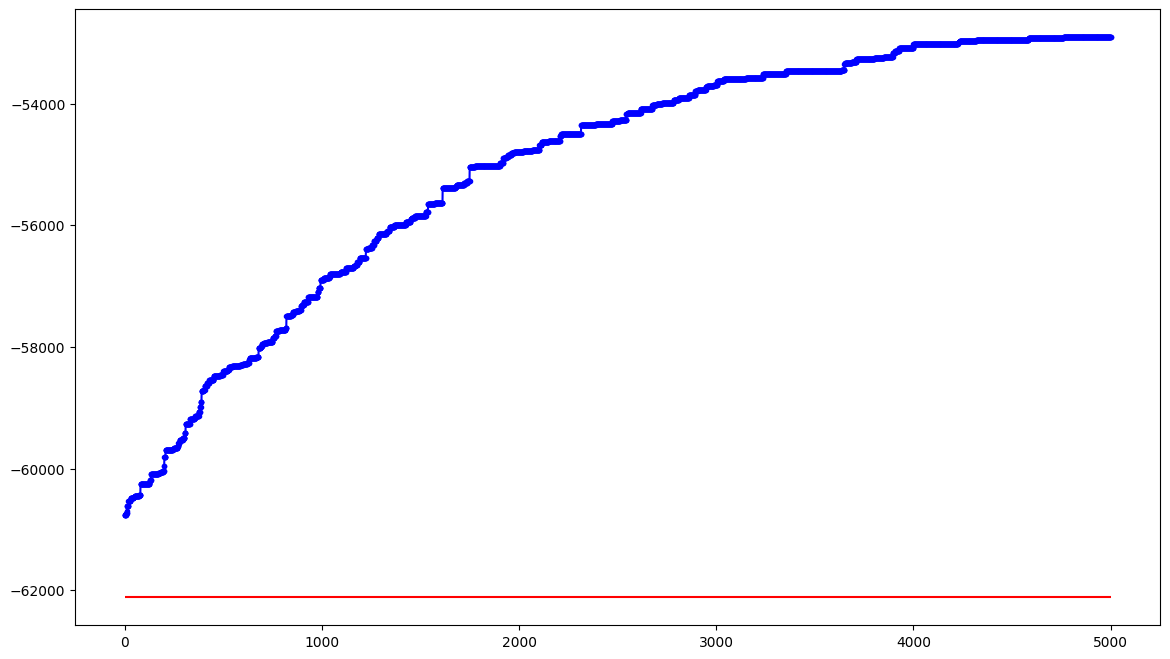

Greedy solution: -62116.045
Cost calls: 726
EA solution: -52910.648
Best solution: -52910.648
Number of steps: 4796


In [181]:
solve(PATH, INSTANCES)